# Notebook pour la visualisation des coraux selon leur position
Installation de :
- jupyter-lab
- sklearn
- pandas
- geopandas
- matplotlib
- numpy
- missingno


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.cluster import DBSCAN
import numpy as np 
import pandas as pd
import missingno as msn

# Lecture des données + planisphère

In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
coraux = gpd.read_file('../data/out/coraux_geo.geojson')

In [3]:
if 'ScientificName' not in coraux.keys():
    coraux['ScientifName'] = coraux['species']
coraux.head()

,CatalogNumber,ScientificName,VernacularNameCategory,TaxonRank,latitude,longitude,DepthInMeters,Locality,phosphate.csv,oxygen.csv,salinity.csv,temperature.csv,nitrate.csv,geometry
0,625366,Madrepora oculata,stony coral (branching),species,18.30817,-158.45392,959,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45392 18.30817)
1,625373,Madrepora oculata,stony coral (branching),species,18.30864,-158.45393,953,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45393 18.30864)
2,625386,Madrepora oculata,stony coral (branching),species,18.30877,-158.45384,955,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45384 18.30877)
3,625382,Madrepora oculata,stony coral (branching),species,18.30875,-158.45384,955,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45384 18.30875)
4,625384,Madrepora oculata,stony coral (branching),species,18.30902,-158.45425,968,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45425 18.30902)


# Affiche tous les coraux sur un planisphère
1 couleur == 1 type de corail

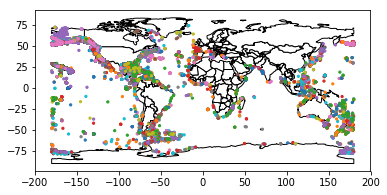

In [4]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
base = world.plot(ax=ax, color='white', edgecolor='black')
coraux.plot(ax=ax, marker='o', markersize=5, column="ScientificName")
# plt.show();

# Description des données des coraux

In [5]:
print(coraux.head())
nb_coraux_unique = len(coraux.ScientificName.unique())
print("\n Le nombre de coraux est de {} pour {} espèces".format(len(coraux.ScientificName), nb_coraux_unique))
print("\n La répartition est :\n{}".format(coraux.ScientificName.value_counts()))


   CatalogNumber     ScientificName   VernacularNameCategory TaxonRank  \
0         625366  Madrepora oculata  stony coral (branching)   species   
1         625373  Madrepora oculata  stony coral (branching)   species   
2         625386  Madrepora oculata  stony coral (branching)   species   
3         625382  Madrepora oculata  stony coral (branching)   species   
4         625384  Madrepora oculata  stony coral (branching)   species   

   latitude  longitude  DepthInMeters  \
0  18.30817 -158.45392            959   
1  18.30864 -158.45393            953   
2  18.30877 -158.45384            955   
3  18.30875 -158.45384            955   
4  18.30902 -158.45425            968   

                                   Locality  phosphate.csv  oxygen.csv  \
0  Hawaiian Archipelago, Swordfish Seamount       3.141286    1.066357   
1  Hawaiian Archipelago, Swordfish Seamount       3.141286    1.066357   
2  Hawaiian Archipelago, Swordfish Seamount       3.141286    1.066357   
3  Hawaiian 

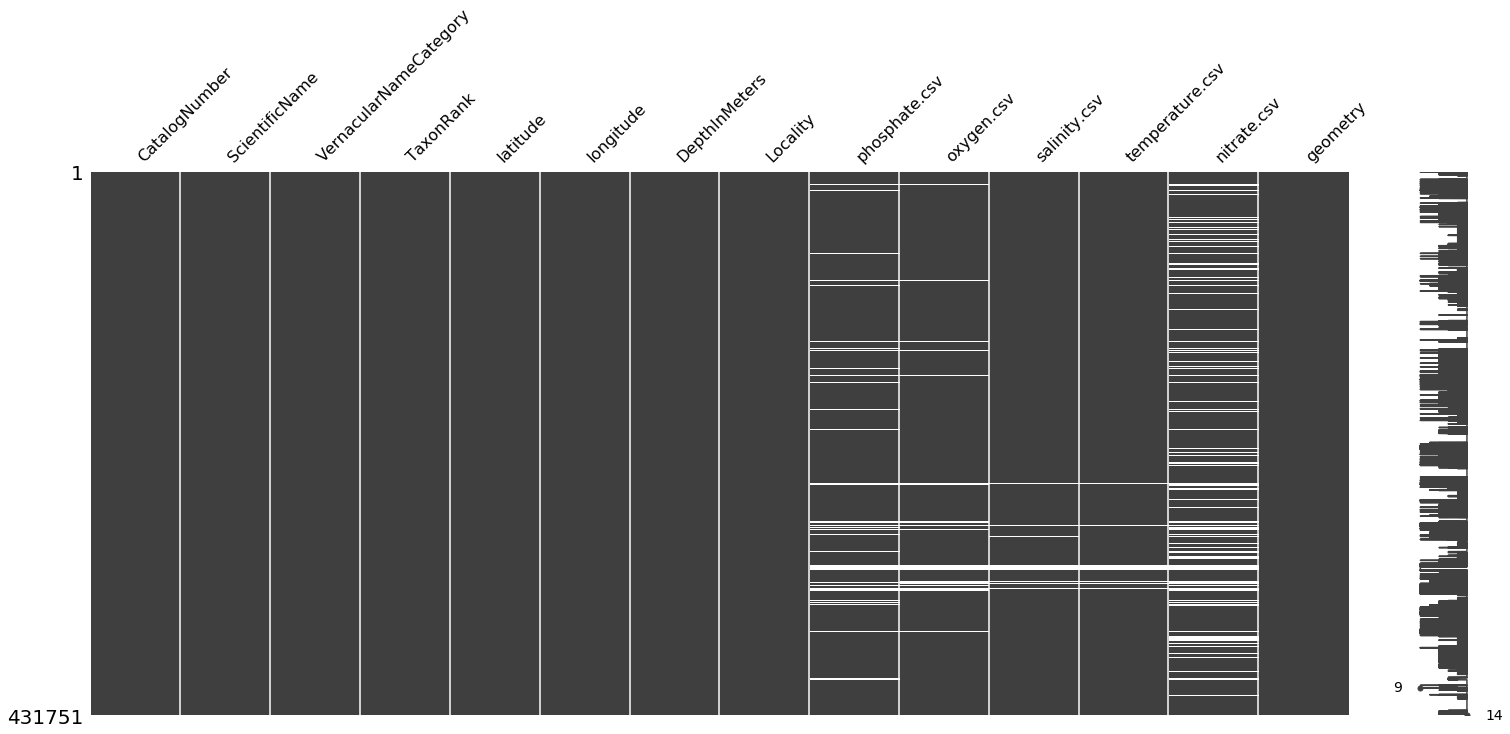

In [6]:

# coraux.info()
# coraux.describe()
# msn.bar(coraux,  color='darkolivegreen')
msn.matrix(coraux)

In [7]:
print("Len Tab duplicate {}".format(len(coraux)))
column_dupli =["ScientificName", "longitude", "latitude", "phosphate.csv" , "oxygen.csv", "salinity.csv", "temperature.csv","nitrate.csv"]

coraux_drop = coraux.drop_duplicates(subset=column_dupli)
print("Len Tab without duplicate {}".format(len(coraux_drop)))
coraux_drop.head(100)

Len Tab duplicate 431751
Len Tab without duplicate 290348


,CatalogNumber,ScientificName,VernacularNameCategory,TaxonRank,latitude,longitude,DepthInMeters,Locality,phosphate.csv,oxygen.csv,salinity.csv,temperature.csv,nitrate.csv,geometry
0,625366,Madrepora oculata,stony coral (branching),species,18.30817,-158.45392,959,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45392 18.30817)
1,625373,Madrepora oculata,stony coral (branching),species,18.30864,-158.45393,953,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45393 18.30864)
2,625386,Madrepora oculata,stony coral (branching),species,18.30877,-158.45384,955,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45384 18.30877)
3,625382,Madrepora oculata,stony coral (branching),species,18.30875,-158.45384,955,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45384 18.30875)
4,625384,Madrepora oculata,stony coral (branching),species,18.30902,-158.45425,968,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45425 18.30902)
5,625375,Madrepora oculata,stony coral (branching),species,18.30746,-158.45412,976,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45412 18.30746)
6,625367,Madrepora oculata,stony coral (branching),species,18.30839,-158.45392,958,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45392 18.30839)
7,625370,Madrepora oculata,stony coral (branching),species,18.30848,-158.45395,953,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45395 18.30848)
8,625381,Madrepora oculata,stony coral (branching),species,18.30845,-158.45393,957,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45393 18.30845)
9,625371,Madrepora oculata,stony coral (branching),species,18.30849,-158.45396,953,"Hawaiian Archipelago, Swordfish Seamount",3.141286,1.066357,34.514391,4.363131,NaN,POINT (-158.45396 18.30849)


In [8]:
### Checke si les données sont variées
column_dupli =["ScientificName", "phosphate.csv" , "oxygen.csv", "salinity.csv", "temperature.csv","nitrate.csv"]
df_stat = coraux.groupby(column_dupli, as_index=False).size().reset_index().rename(columns={0:'count'}).sort_values(by="count", ascending=False)
df_stat.head(20)

,ScientificName,phosphate.csv,oxygen.csv,salinity.csv,temperature.csv,nitrate.csv,count
7941,Calcigorgia beringi,1.627683,4.693200,32.852651,8.704581,16.520567,5474
28817,Latrunculia sp.,1.627683,4.693200,32.852651,8.704581,16.520567,4855
30357,Lophelia pertusa,1.697917,2.767667,35.081547,8.978250,26.491273,4664
18098,Funiculina sp.,3.145250,0.514000,34.415243,4.262660,42.391750,4414
46150,Stylaster sp.,2.533250,2.035750,33.954014,6.564318,34.008500,4049
30375,Lophelia pertusa,1.774000,2.846600,35.010892,8.305698,26.867125,2382
30364,Lophelia pertusa,1.731636,2.825417,35.034494,8.523351,26.557600,2221
30349,Lophelia pertusa,1.676500,2.763286,35.109985,9.204866,26.505154,2131
29171,Leiopathes glaberrima,1.697917,2.767667,35.081547,8.978250,26.491273,2037
1159,Acanthoptilum sp.,1.554167,4.336708,33.545092,11.056604,16.112125,1989


In [9]:
# coraux[coraux['nitrate.csv'].isin('NaN') == True]

print("Nb data with Nitrate with Nan {}".format(len(coraux[coraux['nitrate.csv'].isnull()])))
print("Nb data with Phosphate with Nan {}".format(len(coraux[coraux['phosphate.csv'].isnull()])))
print("Nb data with Oxygen with Nan {}".format(len(coraux[coraux['oxygen.csv'].isnull()])))
print("Nb data with Salinity with Nan {}".format(len(coraux[coraux['salinity.csv'].isnull()])))
print("Nb data with Temperature with Nan {}".format(len(coraux[coraux['temperature.csv'].isnull()])))

print("Nb data with Nan {}".format(len(coraux[coraux.isnull().any(axis=1)])))
print("Nb data {}".format(len(coraux)))
coraux.head()
# group_by_carac = coraux.groupby(["ScientificName", "phosphate.csv" , "oxygen.csv", "salinity.csv", "temperature.csv","nitrate.csv"],as_index=False)
# 
grouped_duplicate = coraux[coraux.duplicated(column_dupli) == True] #.sort_values(by=column_dupli, ascending=[True, False, False, False, False, False]) #.groupby("ScientificName")
grouped_duplicate.head(100)
print("len duplicate {}".format(len(grouped_duplicate)))

Nb data with Nitrate with Nan 73965
Nb data with Phosphate with Nan 31328
Nb data with Oxygen with Nan 18852
Nb data with Salinity with Nan 7995
Nb data with Temperature with Nan 6963
Nb data with Nan 74486
Nb data 431751
len duplicate 363244


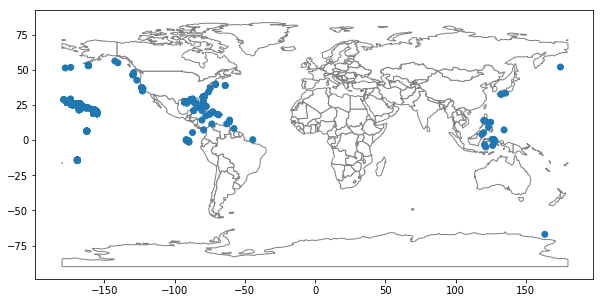

In [10]:
#Affiche le type de coraux indiqué dans type_coraux_to_show
fig, ax = plt.subplots(figsize=[10, 6])
type_coraux_to_show = ["Chrysogorgia sp."] #, "Lophelia pertusa", "Calcigorgia beringi", "Latrunculia sp."]
ax.set_aspect('equal')
base = world.plot(ax=ax, color='white', edgecolor='grey')

coraux[coraux['ScientificName'].isin(type_coraux_to_show) == True].plot(ax=base, column="ScientificName");


# Regroupe les données selon leur position
- Ne garde que les n coraux qui ont un nombre max de d'échantillons
- Juste pour tester des fonctions et réduire les temps de calcul

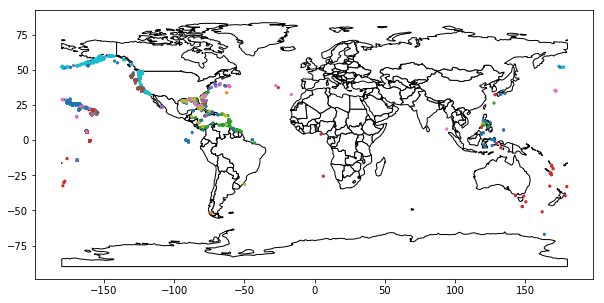

In [11]:
fig, ax = plt.subplots(figsize=[10, 6])
ax.set_aspect('equal')
# coraux.ScientificName.value_counts().keys().tolist() #keys
# coraux.ScientificName.value_counts().tolist() ## value
counts = coraux['ScientificName'].value_counts()

nb_de_data_max = 1000
nb_coraux_filtres = 10
coraux_filtres = coraux[coraux['ScientificName'].isin(counts[counts <nb_de_data_max].index[:nb_coraux_filtres])]
base = world.plot(ax=ax, color='white', edgecolor='black')
coraux_filtres.plot(ax=ax, marker='o', markersize=5, column="ScientificName")
#ax.set_title('Coraux filtrés: les {} coraux contenant max {} positions'.format(nb_coraux_filtres, nb_de_data_max))
plt.show();

# Regroupe les positions par coraux selon leur densité 

In [12]:
coords = coraux_filtres.as_matrix(columns=['latitude', 'longitude'])
kms_per_radian = 6371.0088
epsilon = 1000 / kms_per_radian #
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords)) 
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))


/home/elodiedellier/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


Number of clusters: 8


/home/elodiedellier/.local/lib/python2.7/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)
/home/elodiedellier/.local/lib/python2.7/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


(0, (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0), 0)
(1, (0.8853517877739331, 0.3190311418685121, 0.29042675893886966, 1.0), 0)
(2, (0.9873125720876587, 0.6473663975394078, 0.3642445213379469, 1.0), 0)
(3, (0.9971549404075356, 0.9118031526336025, 0.6010765090349866, 1.0), 0)
(4, (0.9288735101883892, 0.9715494040753557, 0.6380622837370243, 1.0), 0)
(5, (0.6334486735870821, 0.8521337946943485, 0.6436755094194541, 1.0), 5)
(6, (0.2800461361014994, 0.6269896193771626, 0.7024221453287197, 1.0), 0)
(-1, [0, 0, 0, 1], 46)


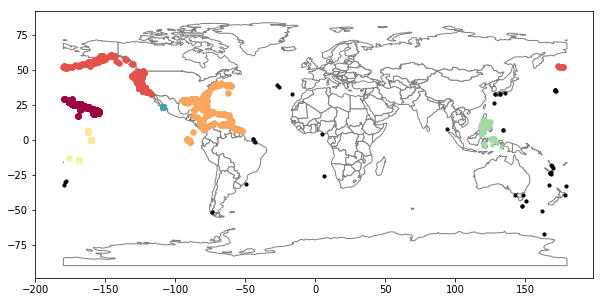

In [13]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Black removed and is used for noise instead.
labels = cluster_labels
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

fig, ax = plt.subplots(figsize=[10, 6])
base = world.plot(ax=ax, color='white', edgecolor='gray')
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = coraux_filtres[class_member_mask & core_samples_mask]
    xy.plot(ax=ax, marker='o',color=col, markersize=30, column="ScientificName")
    xy = coraux_filtres[class_member_mask & ~core_samples_mask]
    xy.plot(ax=ax, marker='o',color=col, markersize=10, column="ScientificName")
    print(k, col, len(xy))
plt.show()   

# Regroupe les positions par coraux selon leur densité selon l'espèce
1 couleur == 1 région contenant une densité de coraux satisfaisantes

Number of clusters: Chrysogorgia sp. 7 set([0, 1, 2, 3, 4, 5, -1])
	Chrysogorgia sp. 0 818 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Chrysogorgia sp. 1 88 (0.8472126105344099, 0.2612072279892349, 0.30519031141868513, 1.0)
	Chrysogorgia sp. 2 12 (0.9637831603229527, 0.47743175701653207, 0.28581314878892733, 1.0)
	Chrysogorgia sp. 3 23 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587, 1.0)
	Chrysogorgia sp. 4 15 (0.9977700884275279, 0.930872741253364, 0.6330642060745867, 1.0)
	Chrysogorgia sp. 5 24 (0.944252210688197, 0.9777008842752788, 0.6620530565167244, 1.0)
	Chrysogorgia sp. -1 6 [0, 0, 0, 1]


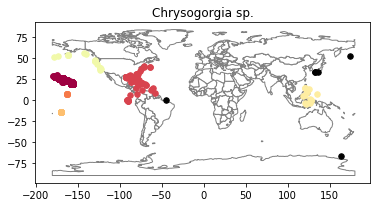

Number of clusters: Desmophyllum sp. 2 set([0, -1])
	Desmophyllum sp. 0 845 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Desmophyllum sp. -1 8 [0, 0, 0, 1]


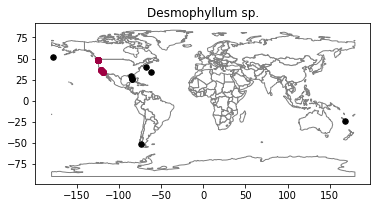

Number of clusters: Ellisella sp. 2 set([0, -1])
	Ellisella sp. 0 920 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Ellisella sp. -1 6 [0, 0, 0, 1]


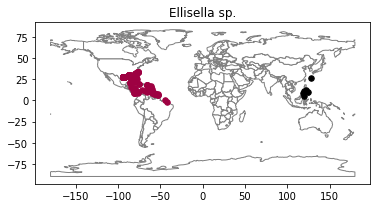

Number of clusters: Enallopsammia rostrata 4 set([0, 1, 2, -1])
	Enallopsammia rostrata 0 948 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Enallopsammia rostrata 1 13 (0.8472126105344099, 0.2612072279892349, 0.30519031141868513, 1.0)
	Enallopsammia rostrata 2 10 (0.9637831603229527, 0.47743175701653207, 0.28581314878892733, 1.0)
	Enallopsammia rostrata -1 26 [0, 0, 0, 1]


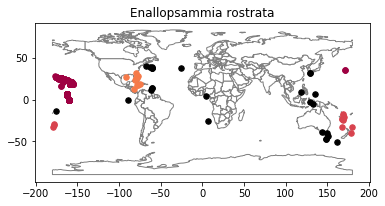

Number of clusters: Euplectellidae 5 set([0, 1, 2, 3, -1])
	Euplectellidae 0 13 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Euplectellidae 1 30 (0.8472126105344099, 0.2612072279892349, 0.30519031141868513, 1.0)
	Euplectellidae 2 873 (0.9637831603229527, 0.47743175701653207, 0.28581314878892733, 1.0)
	Euplectellidae 3 24 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587, 1.0)
	Euplectellidae -1 2 [0, 0, 0, 1]


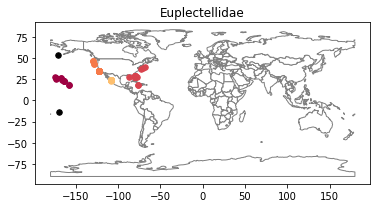

Number of clusters: Farrea truncata 2 set([0, -1])
	Farrea truncata 0 869 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Farrea truncata -1 4 [0, 0, 0, 1]


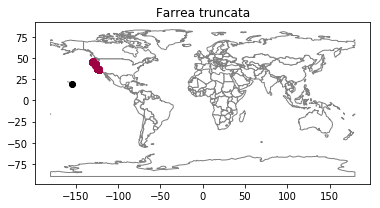

Number of clusters: Leiopathes sp. 3 set([0, 1, -1])
	Leiopathes sp. 0 331 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Leiopathes sp. 1 581 (0.8472126105344099, 0.2612072279892349, 0.30519031141868513, 1.0)
	Leiopathes sp. -1 3 [0, 0, 0, 1]


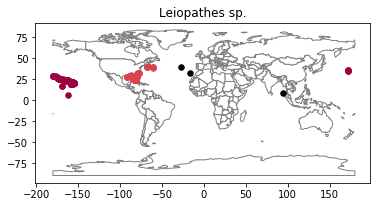

Number of clusters: Lepidisis olapa 1 set([0])
	Lepidisis olapa 0 910 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)


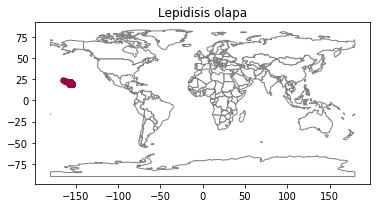

Number of clusters: Nicella sp. 2 set([0, -1])
	Nicella sp. 0 833 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Nicella sp. -1 3 [0, 0, 0, 1]


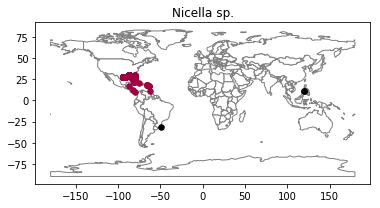

Number of clusters: Ptilosarcus gurneyi 1 set([0])
	Ptilosarcus gurneyi 0 887 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)


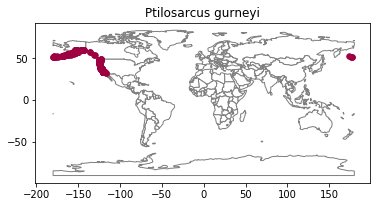

10


In [14]:
grouped = coraux_filtres.groupby('ScientificName')


nb=0
for name, group in grouped:
    coords = group[['latitude', 'longitude']] 
    kms_per_radian = 6371.0088
    epsilon = 1500 / kms_per_radian #1.5
    db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords)) 
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    
    
    if not(num_clusters == 1 and set(cluster_labels) == set([-1])):
        print('Number of clusters: {} {} {}'.format(name, num_clusters, set(cluster_labels)))
        # Affiche le résultat
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True

        # Black removed and is used for noise instead.
        labels = cluster_labels
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, nb_coraux_filtres)]
        fig, ax = plt.subplots()#figsize=[10, 6])
        base = world.plot(ax=ax, color='white', edgecolor='gray')
        for k, col in zip(unique_labels, colors):
            col = [0, 0, 0, 1] if k == -1 else col
            class_member_mask = (labels == k)
            xy = group[(class_member_mask & core_samples_mask) | (class_member_mask & ~core_samples_mask)]
            #print(xy.head())
            print('\t{} {} {} {}'.format(name, k, len(xy), col))
            if len(xy) > 0:
                xy.plot(ax=ax, marker='o', color=col, markersize=30)#, column="ScientificName")
                ax.set_title('{}'.format(name))
        plt.show() 
        nb = nb+1
    
    #print name
print(nb)